In [ ]:
import pandas as pd

split_to_year = {
    'train': '2022',
    'val': '2023',
    'test': '2024'
}

# Process each year
for split, year in split_to_year.items():
    # Read Model 1 data
    model1_file = f"{split}_predictions_1.csv"
    model1 = pd.read_csv(
        model1_file,
        names=['topicname', f'groundtruth{year}', f'model1{year}'],
        skiprows=1
    )

    # Read Model 2 data
    model2_file = f"{split}_predictions_2.csv"
    model2 = pd.read_csv(
        model2_file,
        names=['topicname', f'model2{year}'],
        skiprows=1
    )

    # Read Model 3 data
    model3_file = f"{split}_predictions_3.csv"
    model3 = pd.read_csv(
        model3_file,
        names=['topicname', f'actual_{year}', f'model3{year}'],

    )
    # Keep only the prediction from Model 3
    model3 = model3[['topicname', f'model3{year}']]

    yearly_data = model1.merge(model2, on='topicname', how='left')
    yearly_data = yearly_data.merge(model3, on='topicname', how='left')

    column_order = [
        'topicname',
        f'groundtruth{year}',
        f'model1{year}',
        f'model2{year}',
        f'model3{year}'
    ]
    yearly_data = yearly_data[column_order]

    yearly_data.to_csv(f'predictions_{year}.csv', index=False)
    print(f"Saved predictions for {year} to predictions_{year}.csv")


Saved predictions for 2022 to predictions_2022.csv
Saved predictions for 2023 to predictions_2023.csv
Saved predictions for 2024 to predictions_2024.csv


In [1]:
!pip install -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, Add
from sentence_transformers import SentenceTransformer

# Load and Preprocess Data

def load_and_preprocess(year):
    filename = f"predictions_{year}.csv"
    df = pd.read_csv(filename)
    cols = ['topicname', f'groundtruth{year}', f'model1{year}', f'model2{year}', f'model3{year}']
    df = df[cols]

    # Fill missing values for model2 and model3 with model1's value
    for col in [f'model2{year}', f'model3{year}']:
        df[col].fillna(df[f'model1{year}'], inplace=True)

    # Apply log1p transformation to compress large ranges
    for col in [f'model1{year}', f'model2{year}', f'model3{year}', f'groundtruth{year}']:
        df[col] = np.log1p(df[col])

    df[f'model_mean{year}'] = df[[f'model1{year}', f'model2{year}', f'model3{year}']].mean(axis=1)

    for col in [f'model1{year}', f'model2{year}', f'model3{year}']:
        df[f'diff_{col}_{year}'] = df[col] - df[f'model_mean{year}']

    topics = df['topicname'].tolist()
    return df, topics

df_train, topics_train = load_and_preprocess("2022")
df_val, topics_val     = load_and_preprocess("2023")
df_test, topics_test   = load_and_preprocess("2024")

print("Numeric preprocessing complete. (Example from train set)")
print(df_train.head())

Numeric preprocessing complete. (Example from train set)
                     topicname  groundtruth2022  model12022  model22022  \
0         cross-site scripting         9.038365    9.141954    9.353467   
1           runtime management         7.474205    7.550661    7.652938   
2                communication         7.636752    7.727535    7.788463   
3  inference time optimization         9.017968    9.101641    9.231163   
4                     jpeg2000         8.681181    8.802522    9.004023   

   model32022  model_mean2022  diff_model12022_2022  diff_model22022_2022  \
0    9.051110        9.182177             -0.040223              0.171290   
1    7.493317        7.565639             -0.014978              0.087299   
2    7.633370        7.716456              0.011079              0.072007   
3    9.031812        9.121539             -0.019898              0.109624   
4    8.695172        8.833906             -0.031383              0.170117   

   diff_model32022_2022  
0  

<ipython-input-2-4747bf0d1338>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[f'model1{year}'], inplace=True)
<ipython-input-2-4747bf0d1338>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np

sentence_model = SentenceTransformer('all-mpnet-base-v2')

def get_topic_embeddings(topics):
    embeddings = sentence_model.encode(topics, batch_size=32, show_progress_bar=True)
    return np.array(embeddings, dtype=np.float32)

X_train_topic = get_topic_embeddings(topics_train)
X_val_topic = get_topic_embeddings(topics_val)
X_test_topic = get_topic_embeddings(topics_test)

print("Topic embeddings generated for train, validation, and test sets using all-mpnet-base-v2.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Topic embeddings generated for train, validation, and test sets using all-mpnet-base-v2.


In [4]:
def prepare_numeric_features(df, year):
    feature_cols = [
        f'model1{year}', f'model2{year}', f'model3{year}',
        f'model_mean{year}',
        f'diff_model1_{year}', f'diff_model2_{year}', f'diff_model3_{year}'
    ]
    rename_dict = {
        f'diff_model1{year}_{year}': f'diff_model1_{year}',
        f'diff_model2{year}_{year}': f'diff_model2_{year}',
        f'diff_model3{year}_{year}': f'diff_model3_{year}',
    }
    df = df.rename(columns=rename_dict)
    X = df[feature_cols].values.astype(np.float32)
    y = df[f'groundtruth{year}'].values.astype(np.float32)
    return X, y


In [5]:
# Build numeric feature matrices for each split
X_train_num, y_train = prepare_numeric_features(df_train, "2022")
X_val_num, y_val     = prepare_numeric_features(df_val, "2023")
X_test_num, y_test   = prepare_numeric_features(df_test, "2024")

# Scale numeric features using RobustScaler
scaler = RobustScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_val_num   = scaler.transform(X_val_num)
X_test_num  = scaler.transform(X_test_num)

print("Numeric feature extraction and scaling complete.")

Numeric feature extraction and scaling complete.


In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l2

# Define L2 regularization factor
l2_reg = 1e-4

# Numeric input branch.
num_input = Input(shape=(X_train_num.shape[1],), name='num_input')
# Use L2 regularization in Dense layers
x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_numeric_1')(num_input)
x = Dropout(0.2, name='dropout_numeric_1')(x)

# Dynamic gating: learn to re-weight the numeric features.
gate = Dense(X_train_num.shape[1], activation='softmax', kernel_regularizer=l2(l2_reg), name='gating_weights')(x)
weighted = Multiply(name='weighted_numeric')([num_input, gate])

x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_numeric_2')(weighted)
x = Dropout(0.2, name='dropout_numeric_2')(x)

# Topic embedding branch.
topic_input = Input(shape=(X_train_topic.shape[1],), name='topic_input')
t = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name='dense_topic_1')(topic_input)
t = Dropout(0.2, name='dropout_topic')(t)

# Fusion stage
fusion = Concatenate(name='fusion_concat')([x, t])
fusion = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name='fusion_dense_1')(fusion)
fusion = Dropout(0.2, name='fusion_dropout_1')(fusion)

# Highway block for adaptive fusion
highway_gate = Dense(128, activation='sigmoid', kernel_regularizer=l2(l2_reg), name='highway_gate')(fusion)
transform    = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg), name='highway_transform')(fusion)

one_minus_gate = Lambda(lambda x: 1.0 - x, name='one_minus_gate')(highway_gate)

# (highway_gate * transform) + ((1 - highway_gate) * fusion)
highway = Add(name='highway_out')([
    Multiply(name='highway_transform_mul')([highway_gate, transform]),
    Multiply(name='highway_carry_mul')([one_minus_gate, fusion])
])

fusion = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg), name='fusion_dense_2')(highway)
fusion = Dropout(0.2, name='fusion_dropout_2')(fusion)

output = Dense(1, activation='linear', kernel_regularizer=l2(l2_reg), name='output')(fusion)

model = Model(inputs=[num_input, topic_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ num_input           │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_numeric_1     │ (None, 64)        │        512 │ num_input[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_numeric_1   │ (None, 64)        │          0 │ dense_numeric_1[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gating_weights      │ (None, 7)         │        455 │ dropout_numeric_… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_numeric    │ (None, 7)         │          0 │ num_input[0][0],  │
│ (Multiply)          │                   │            │ gating_weights[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ topic_input         │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_numeric_2     │ (None, 64)        │        512 │ weighted_numeric… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_topic_1       │ (None, 128)       │     98,432 │ topic_input[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_numeric_2   │ (None, 64)        │          0 │ dense_numeric_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_topic       │ (None, 128)       │          0 │ dense_topic_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 192)       │          0 │ dropout_numeric_… │
│ (Concatenate)       │                   │            │ dropout_topic[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense_1      │ (None, 128)       │     24,704 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout_1    │ (None, 128)       │          0 │ fusion_dense_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highway_gate        │ (None, 128)       │     16,512 │ fusion_dropout_1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highway_transform   │ (None, 128)       │     16,512 │ fusion_dropout_1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_minus_gate      │ (None, 128)       │          0 │ highway_gate[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highway_transform_… │ (None, 128)       │          0 │ highway_gate[0][

 Total params: 165,960 (648.28 KB)

 Trainable params: 165,960 (648.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
EPOCHS = 200
BATCH_SIZE = 32

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model using train and validation sets.
history = model.fit(
    [X_train_num, X_train_topic], y_train,
    validation_data=([X_val_num, X_val_topic], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

# Evaluate on the test set.
test_loss = model.evaluate([X_test_num, X_test_topic], y_test, batch_size=BATCH_SIZE)
print(f"\nTest Loss (MSE): {test_loss:.4f}")

Epoch 1/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 16.1636 - val_loss: 0.3009
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.8936 - val_loss: 0.1481
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6781 - val_loss: 0.1629
Epoch 4/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6609 - val_loss: 0.1190
Epoch 5/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6274 - val_loss: 0.1236
Epoch 6/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6150 - val_loss: 0.1691
Epoch 7/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6037 - val_loss: 0.0956
Epoch 8/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5818 - val_loss: 0.1029
Epoch 9/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5685 - val_loss: 0.1647
Epoch 10/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5457 - val_loss: 0.1542
Epoch 11/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5355 - val_loss: 0.1526
Epoch 12/200
250/250 ━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import mean_squared_error


predictions = model.predict([X_test_num, X_test_topic])
results_df = pd.DataFrame({
    'topicname': topics_test,
    'groundtruth': np.expm1(y_test),
    'predicted': np.expm1(predictions.flatten())
})
print(results_df.head())

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                  topicname  groundtruth    predicted
0  variational inequalities  6861.001953  7242.317383
1       gesture recognition  2138.000000  1690.864014
2           interval models  3617.000977  3037.685547
3           delta debugging  5578.997559  5114.788086
4           railway control   229.000015   155.797928


In [ ]:
import math
# Inverse the log1p transformation to get back the original values.
predictions_original = np.expm1(predictions)
groundtruth = np.expm1(y_test)

# Calculate MSE on the original scale.
mse_score = mean_squared_error(groundtruth, predictions_original)
rmse = math.sqrt(mse_score)
print(rmse)


2150.4850615616933


In [ ]:
groundtruth_test = np.expm1(df_test[f'groundtruth2024'].values.astype(np.float32))

# Model predictions on test set:
model1_pred_test = np.expm1(df_test[f'model12024'].values.astype(np.float32))
model2_pred_test = np.expm1(df_test[f'model22024'].values.astype(np.float32))
model3_pred_test = np.expm1(df_test[f'model32024'].values.astype(np.float32))

# Calculate RMSE for each model.
mse_model1 = mean_squared_error(groundtruth_test, model1_pred_test)
rmse_model1 = np.sqrt(mse_model1)

mse_model2 = mean_squared_error(groundtruth_test, model2_pred_test)
rmse_model2 = np.sqrt(mse_model2)

mse_model3 = mean_squared_error(groundtruth_test, model3_pred_test)
rmse_model3 = np.sqrt(mse_model3)

print("Test RMSE (original scale):")
print(f"Model 1: {rmse_model1:.4f}")
print(f"Model 2: {rmse_model2:.4f}")
print(f"Model 3: {rmse_model3:.4f}")

Test RMSE (original scale):
Model 1: 2501.0642
Model 2: 4110.1071
Model 3: 3306.2477


In [ ]:
model.save('ensemble_model.h5')

In [6]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error

# Load the saved ensemble model
model = load_model('ensemble_model.h5')
predictions_original = np.expm1(model.predict([X_test_num, X_test_topic]).flatten())
groundtruth_test = np.expm1(df_test[f'groundtruth2024'].values.astype(np.float32))
model1_pred_test = np.expm1(df_test[f'model12024'].values.astype(np.float32))
model2_pred_test = np.expm1(df_test[f'model22024'].values.astype(np.float32))
model3_pred_test = np.expm1(df_test[f'model32024'].values.astype(np.float32))

mape = mean_absolute_percentage_error(groundtruth_test, predictions_original)
mape_model1 = mean_absolute_percentage_error(groundtruth_test, model1_pred_test)
mape_model2 = mean_absolute_percentage_error(groundtruth_test, model2_pred_test)
mape_model3 = mean_absolute_percentage_error(groundtruth_test, model3_pred_test)
print(f"Test MAPE: {mape:.4f}")
print(f"Model 1: {mape_model1:.4f}")
print(f"Model 2: {mape_model2:.4f}")
print(f"Model 3: {mape_model3:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test MAPE: 0.1912
Model 1: 0.2308
Model 2: 0.4877
Model 3: 0.3168


In [7]:
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np

# Calculate MAPE for each topic individually
topic_names = df_test['topicname'].unique()
topic_mapes = []

for topic in topic_names:
    mask = (df_test['topicname'] == topic)
    y_true = groundtruth_test[mask]
    y_pred = predictions_original[mask]

    if len(y_true) > 0:
        topic_mape = mean_absolute_percentage_error(y_true, y_pred)
        topic_mapes.append((topic, topic_mape))

topic_mape_df = pd.DataFrame(topic_mapes, columns=['Topic', 'MAPE'])
topic_mape_df_sorted = topic_mape_df.sort_values('MAPE').reset_index(drop=True)

num_topics = len(topic_mape_df_sorted)

top_5 = topic_mape_df_sorted.head(10)
middle_start = num_topics // 2 - 2
middle_5 = topic_mape_df_sorted.iloc[middle_start:middle_start+10]
bottom_5 = topic_mape_df_sorted.tail(10)

print("Top 5 Topics with Smallest MAPE:")
print(top_5.to_string(index=False))

print("\nMiddle 5 Topics (Median Performance):")
print(middle_5.to_string(index=False))

print("\nTop 5 Topics with Highest MAPE:")
print(bottom_5.to_string(index=False))


Top 5 Topics with Smallest MAPE:
                                      Topic     MAPE
                      saddle point problems 0.000390
    hyperbolic geometry in machine learning 0.001799
reidentification with unsupervised learning 0.001987
                  adaptive gradient methods 0.004501
             neural networks for signatures 0.004674
          asymmetric reinforcement learning 0.006285
          off-policy reinforcement learning 0.006806
                     actor-critic algorithm 0.007627
                     convex hull algorithms 0.008231
                           forward learning 0.008250

Middle 5 Topics (Median Performance):
                                         Topic     MAPE
                 internet service provisioning 0.175053
                          covert communication 0.175286
                                  unix systems 0.175370
                         long-horizon planning 0.175425
                     discrete cosine transform 0.175560
         

In [14]:
import time
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

selected_topics = [
    "learning stability",
    "machine learning for security",
    "adaptive gradient methods",
    "attention economy",
    "tuberculosis detection and diagnosis"
]

selected_mask = df_test['topicname'].isin(selected_topics)
df_selected = df_test[selected_mask].reset_index(drop=True)

X_selected_num = X_test_num[selected_mask]
X_selected_topic = X_test_topic[selected_mask]

groundtruth_selected = groundtruth_test[selected_mask]
model1_selected = model1_pred_test[selected_mask]
model2_selected = model2_pred_test[selected_mask]
model3_selected = model3_pred_test[selected_mask]

model = load_model('ensemble_model.h5')

results = []

for i in range(len(df_selected)):
    x_num = X_selected_num[i:i+1]
    x_topic = X_selected_topic[i:i+1]

    start_time = time.time()
    prediction = model.predict([x_num, x_topic], verbose=0)
    end_time = time.time()

    pred_value = np.expm1(prediction.flatten()[0])

    latency = end_time - start_time

    results.append({
        'Topic': df_selected.loc[i, 'topicname'],
        'Ground Truth': groundtruth_selected[i],
        'Model 1 Prediction': model1_selected[i],
        'Model 2 Prediction': model2_selected[i],
        'Model 3 Prediction': model3_selected[i],
        'Ensemble Prediction': pred_value,
        'Latency (seconds)': latency
    })

results_df = pd.DataFrame(results)

print(results_df.to_string(index=False))


                               Topic  Ground Truth  Model 1 Prediction  Model 2 Prediction  Model 3 Prediction  Ensemble Prediction  Latency (seconds)
                  learning stability   3036.998779         3046.999023         2351.316650         2282.000488          2788.544922           0.262805
       machine learning for security   3446.000977         3039.999023         2550.003418         2488.999512          3026.219727           0.093560
                 federated computing   7043.997559         5540.000000         4549.492676         4608.998047          6075.435059           0.093729
           adaptive gradient methods   5978.000488         5275.001465         3581.728271         4455.001465          5951.090820           0.134435
tuberculosis detection and diagnosis     24.999998           35.999996          274.046326           40.000000            33.959087           0.135048
                      quantum coding   4131.998047         3507.998535         2661.364746    


=== Easy Topics MAPE Results ===
                        Topic  Transformer     LSTM  XGBoost  Ensemble
    adaptive gradient methods     0.117598 0.400848 0.254767  0.004501
machine learning for security     0.117818 0.260011 0.277714  0.121817
        blockchain regulation     0.048971 0.326250 0.329159  0.102196
                  5g networks     0.217063 0.468857 0.323229  0.106475
            foundation models     0.317005 0.415311 0.309427  0.159525

=== Medium Topics MAPE Results ===
                        Topic  Transformer     LSTM  XGBoost  Ensemble
               quantum coding     0.151016 0.355913 0.259680  0.134548
          federated computing     0.213515 0.354132 0.345684  0.137502
internet service provisioning     0.022100 0.300485 0.250460  0.175053
 graph-based machine learning     0.168471 0.372688 0.228382  0.156078
           digital biomarkers     0.243976 0.495729 0.334050  0.143135

=== Hard Topics MAPE Results ===
                          Topic  Transformer

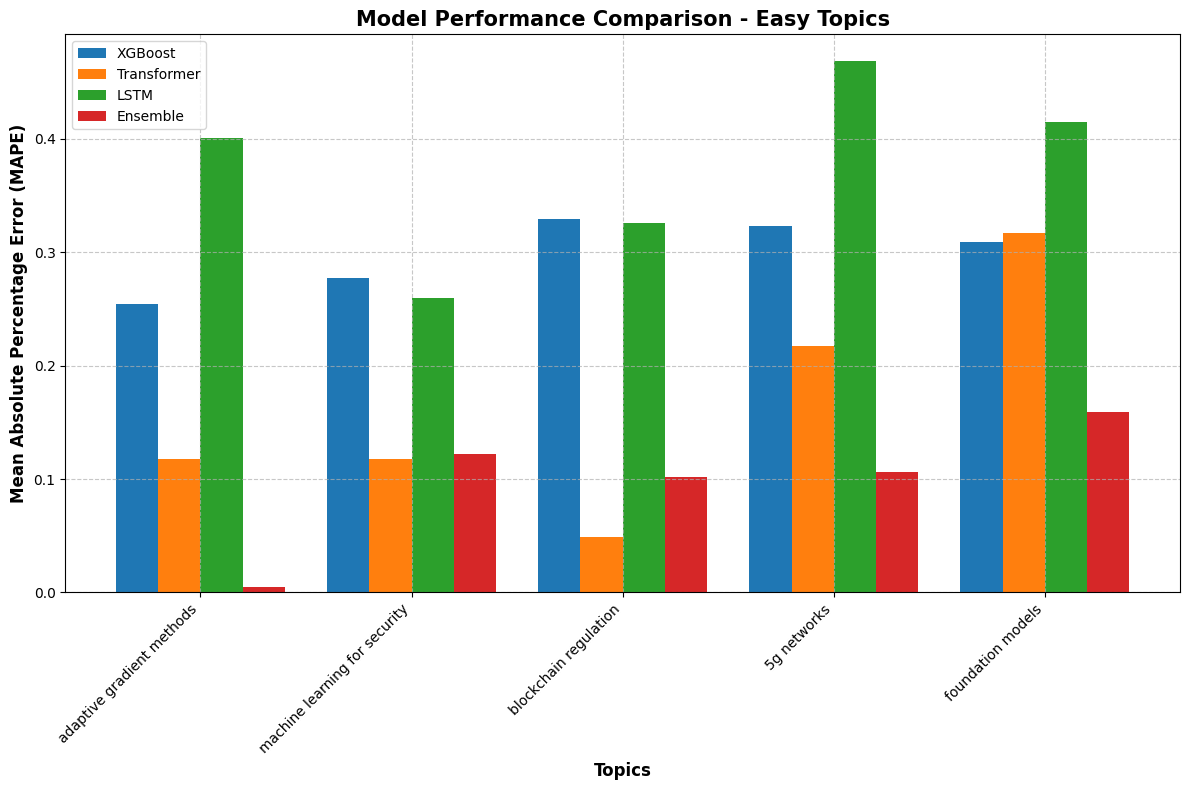

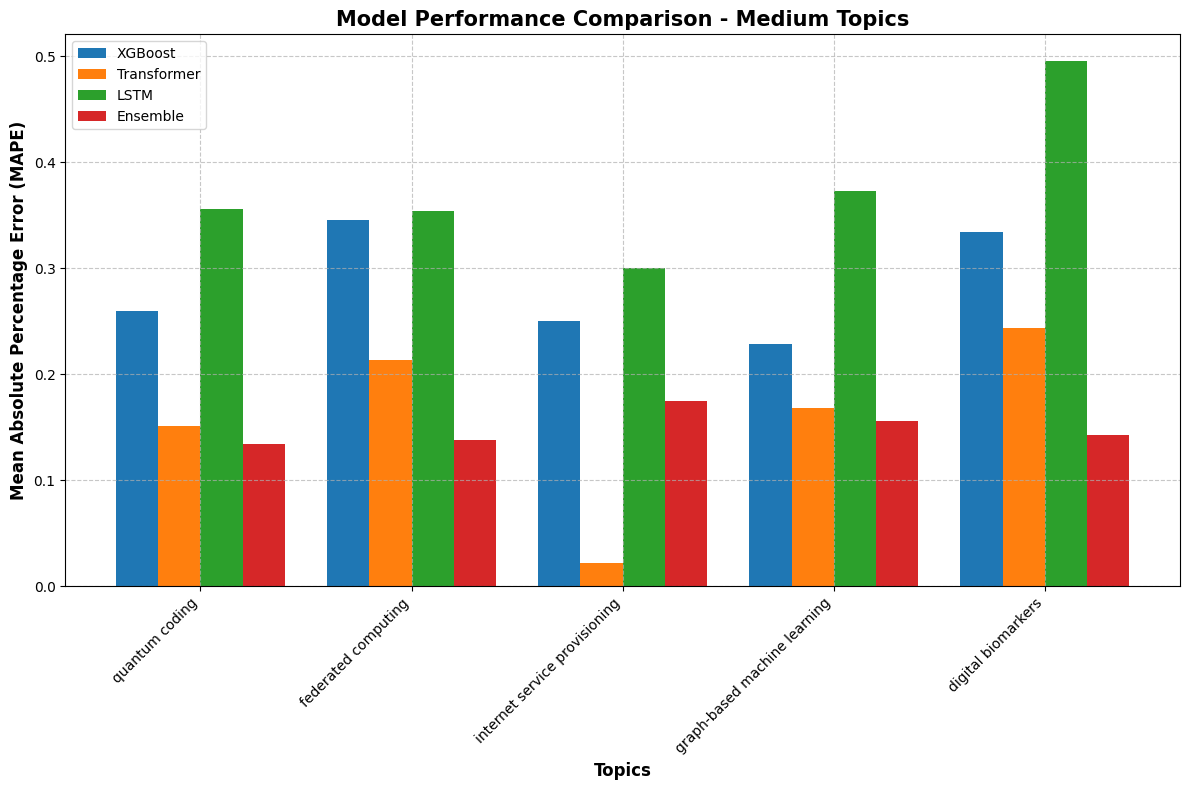

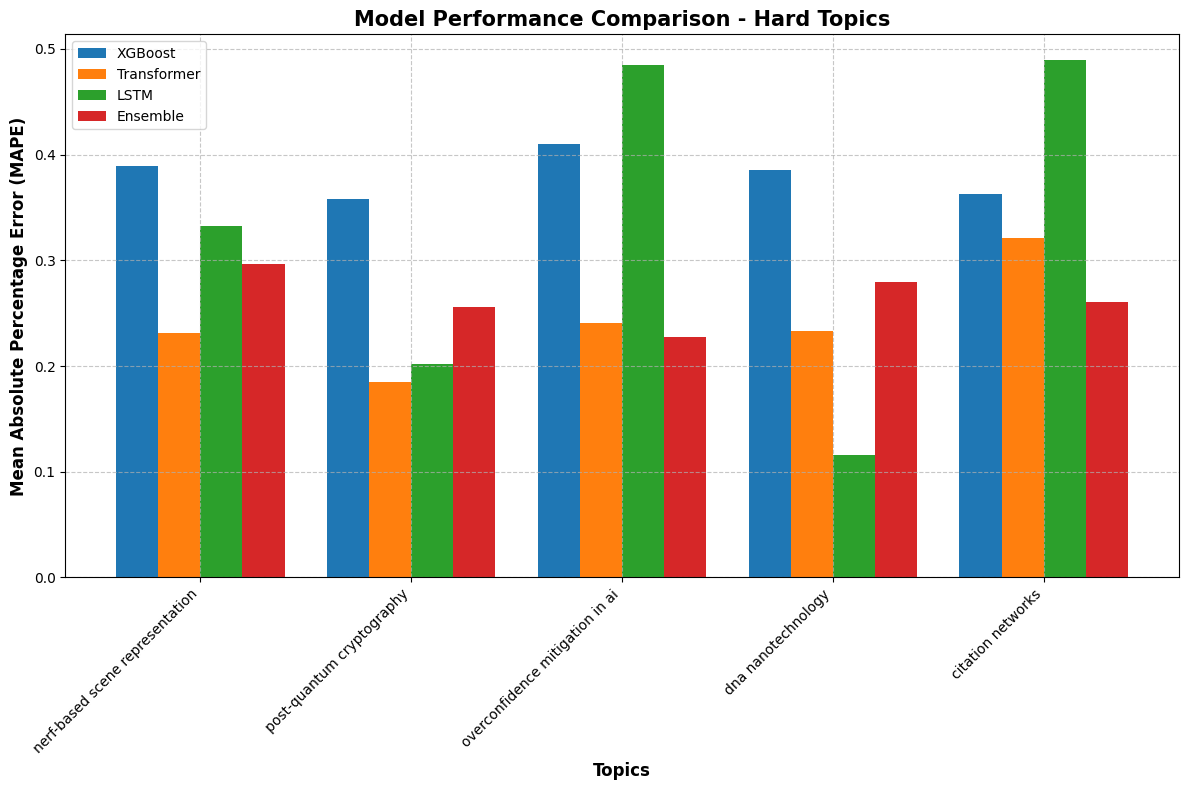

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error

# Define the topics

easy_topics = ['adaptive gradient methods', 'machine learning for security',
               'blockchain regulation', '5g networks', 'foundation models']

medium_topics = ['quantum coding', 'federated computing',
                'internet service provisioning',
                'graph-based machine learning', 'digital biomarkers']

hard_topics = ['nerf-based scene representation', 'post-quantum cryptography',
               'overconfidence mitigation in ai', 'dna nanotechnology',
               'citation networks']
def calculate_topic_mapes(topics, groundtruth_test, predictions_original, df_test):
    results = []

    for topic in topics:
        mask = (df_test['topicname'] == topic)
        y_true = groundtruth_test[mask]
        y_pred_ensemble = predictions_original[mask]

        if len(y_true) > 0:
            try:
                model1_pred = np.expm1(df_test.loc[mask, 'model12024'].values.astype(np.float32))
                model2_pred = np.expm1(df_test.loc[mask, 'model22024'].values.astype(np.float32))
                model3_pred = np.expm1(df_test.loc[mask, 'model32024'].values.astype(np.float32))

                mape1 = mean_absolute_percentage_error(y_true, model1_pred)
                mape2 = mean_absolute_percentage_error(y_true, model2_pred)
                mape3 = mean_absolute_percentage_error(y_true, model3_pred)
                mape_ensemble = mean_absolute_percentage_error(y_true, y_pred_ensemble)

                results.append({
                    'Topic': topic,
                    'Transformer': mape1,
                    'LSTM': mape2,
                    'XGBoost': mape3,
                    'Ensemble': mape_ensemble
                })
            except:
                pass

    if not results:
        raise ValueError("No results could be calculated. Check the topics and column names.")

    return pd.DataFrame(results)

# Plot function
def plot_model_comparison(topic_type, topics_df):
    plt.figure(figsize=(12, 8))

    models = ['XGBoost', 'Transformer', 'LSTM', 'Ensemble']
    topics = topics_df['Topic'].tolist()

    bar_width = 0.2
    r = np.arange(len(topics))

    for i, model in enumerate(models):
        plt.bar(r + i * bar_width, topics_df[model], width=bar_width, label=model)

    plt.xlabel('Topics', fontweight='bold', fontsize=12)
    plt.ylabel('Mean Absolute Percentage Error (MAPE)', fontweight='bold', fontsize=12)
    plt.title(f'Model Performance Comparison - {topic_type} Topics', fontweight='bold', fontsize=15)
    plt.xticks(r + bar_width * 1.5, topics, rotation=45, ha='right')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'{topic_type.lower()}_topics_comparison.png', dpi=300)
    plt.show()

try:
    easy_results = calculate_topic_mapes(easy_topics, groundtruth_test, predictions_original, df_test)
    print("\n=== Easy Topics MAPE Results ===")
    print(easy_results.to_string(index=False))

    medium_results = calculate_topic_mapes(medium_topics, groundtruth_test, predictions_original, df_test)
    print("\n=== Medium Topics MAPE Results ===")
    print(medium_results.to_string(index=False))

    hard_results = calculate_topic_mapes(hard_topics, groundtruth_test, predictions_original, df_test)
    print("\n=== Hard Topics MAPE Results ===")
    print(hard_results.to_string(index=False))

    plot_model_comparison('Easy', easy_results)
    plot_model_comparison('Medium', medium_results)
    plot_model_comparison('Hard', hard_results)

except Exception as e:
    print(f"Error occurred: {e}")


In [ ]:
pip install graphviz

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='Ensemble Model Architecture', format='pdf')

# --- Numeric Input Branch ---
dot.node('A', 'Numeric Input\n(Predictions + Engineered Features)', shape='box')
dot.node('B', 'Dense (64, ReLU, L2)\n+ Dropout (0.2)', shape='box')
dot.node('C', 'Dynamic Gating\n(Dense, Softmax, L2)', shape='box')
dot.node('D', 'Multiply\n(Numeric Input × Gating Weights)', shape='box')
dot.node('E', 'Dense (64, ReLU, L2)\n+ Dropout (0.2)', shape='box')

# --- Topic Embedding Branch ---
dot.node('F', 'Topic Input\n(SentenceBERT Embeddings)', shape='box')
dot.node('G', 'Dense (128, ReLU, L2)\n+ Dropout (0.2)', shape='box')

# --- Fusion Stage ---
dot.node('H', 'Concatenate\n(Numeric Features + Topic Features)', shape='box')
dot.node('I', 'Dense (128, ReLU, L2)\n+ Dropout (0.2)', shape='box')

# --- Highway Block for Adaptive Fusion ---
dot.node('J', 'Highway Gate\n(Dense, Sigmoid, L2)', shape='box')
dot.node('K', 'Transform Branch\n(Dense, ReLU, L2)', shape='box')
dot.node('L', 'Lambda Layer\n(1 - Gate)', shape='box')
dot.node('M', 'Highway Combination\n(Gate × Transform + (1 - Gate) × Fusion)', shape='box')

# --- Post-Highway and Output ---
dot.node('N', 'Dense (64, ReLU, L2)\n+ Dropout (0.2)', shape='box')
dot.node('O', 'Final Output\n(Dense (1, Linear, L2))', shape='box')

# ---------------------- Edges for Numeric Branch ----------------------
dot.edge('A', 'B', label='Numeric Features')
dot.edge('B', 'C')
dot.edge('C', 'D', label='Gating Weights')
dot.edge('A', 'D', style='dashed', label='Original Input')
dot.edge('D', 'E')

# ---------------------- Edges for Topic Branch ----------------------
dot.edge('F', 'G', label='Topic Embeddings')

# ---------------------- Fusion Stage ----------------------
dot.edge('E', 'H')
dot.edge('G', 'H', label='Fusion')
dot.edge('H', 'I')

# ---------------------- Highway Block ----------------------
dot.edge('I', 'J', label='Fused Features')
dot.edge('I', 'K', label='Transformed Features')
dot.edge('K', 'M', label='× Gate')
dot.edge('J', 'L', label='1 - Gate')
dot.edge('I', 'M', label='× (1 - Gate)', style='dotted')

dot.edge('M', 'N')
dot.edge('N', 'O', label='Final Prediction')

dot.render('ensemble_architecture', view=True)

'ensemble_architecture.pdf'

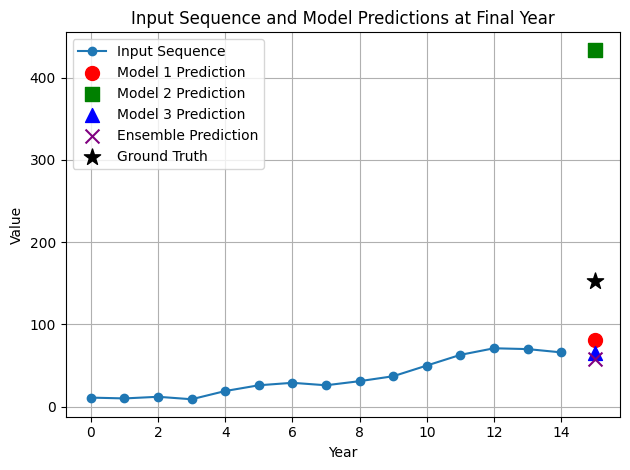

In [4]:
import matplotlib.pyplot as plt
import numpy as np

input_sequence = [11., 10., 12., 9., 19., 26., 29., 26., 31., 37., 50., 63., 71., 70., 66.]

model1_pred = 81
model2_pred = 434
model3_pred = 65
ensemble_pred = 58.271976
ground_truth = 153

years_input = np.arange(len(input_sequence))
year_output = len(input_sequence)

plt.plot(years_input, input_sequence, marker='o', label='Input Sequence')

plt.scatter(year_output, model1_pred, label='Model 1 Prediction', color='red', marker='o', s=100)
plt.scatter(year_output, model2_pred, label='Model 2 Prediction', color='green', marker='s', s=100)
plt.scatter(year_output, model3_pred, label='Model 3 Prediction', color='blue', marker='^', s=100)
plt.scatter(year_output, ensemble_pred, label='Ensemble Prediction', color='purple', marker='x', s=100)
plt.scatter(year_output, ground_truth, label='Ground Truth', color='black', marker='*', s=150)

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Input Sequence and Model Predictions at Final Year')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


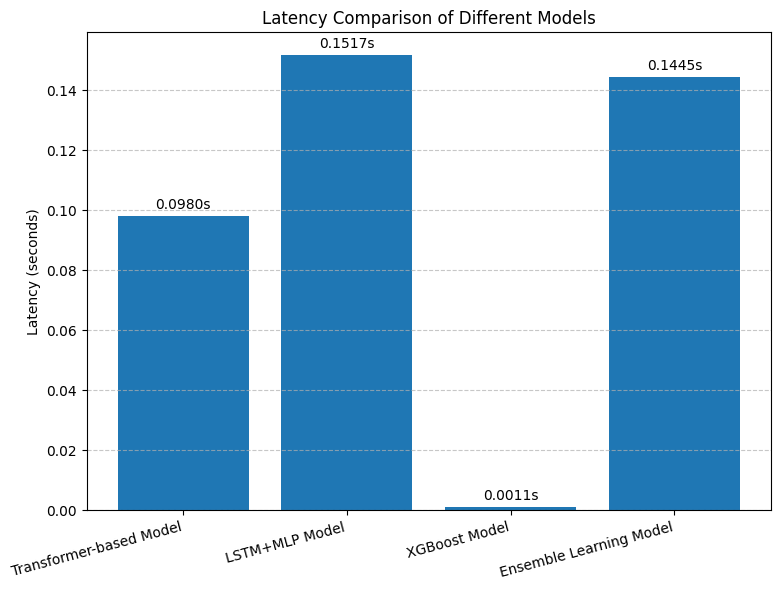

In [5]:
import matplotlib.pyplot as plt

models = ['Transformer-based Model', 'LSTM+MLP Model', 'XGBoost Model', 'Ensemble Learning Model']

latencies = [0.098, 0.1517, 0.00115, 0.144469]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, latencies)

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}s',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison of Different Models')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
